Import modules and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime

%matplotlib inline
#%matplotlib ipympl
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing

# About the data


Trip History Data from https://capitalbikeshare.com/system-data

Quarterly Capital Bikeshare trip data. The data includes:

    Duration – Duration of trip
    Start Date – Includes start date and time
    End Date – Includes end date and time
    Start Station – Includes starting station name and number
    End Station – Includes ending station name and number
    Bike Number – Includes ID number of bike used for the trip [not available in most recent data]
    Member Type – Indicates whether user was a "registered" member (Annual Member, 30-Day Member or Day Key Member) or a "casual" rider (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)

This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure).
NOTE: The 3-Day Membership replaced the 5-Day Membership in Fall 2011

Beware inclusion of dockless bikes and e-scooters after a certain point.


In [2]:
df_2023_04 = pd.read_csv('202304-capitalbikeshare-tripdata.csv')

# Project Goals

Develop KPIs and make predictions

Idea: use demographic information to cross-reference with journey start/end points


# First steps

check shape and column names

In [3]:
display(df_2023_04.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389243 entries, 0 to 389242
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             389243 non-null  object 
 1   rideable_type       389243 non-null  object 
 2   started_at          389243 non-null  object 
 3   ended_at            389243 non-null  object 
 4   start_station_name  360858 non-null  object 
 5   start_station_id    360858 non-null  float64
 6   end_station_name    358630 non-null  object 
 7   end_station_id      358630 non-null  float64
 8   start_lat           389243 non-null  float64
 9   start_lng           389243 non-null  float64
 10  end_lat             388555 non-null  float64
 11  end_lng             388555 non-null  float64
 12  member_casual       389243 non-null  object 
dtypes: float64(6), object(7)
memory usage: 38.6+ MB


None

In [4]:
display(df_2023_04.head())

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member


In [5]:
#set ride_id as index
#TODO: find out if this is a bad idea
#df_2023_04.set_index('ride_id')

check for missing values

In [6]:
display("Empty fields:",df_2023_04.isnull().sum(), df_2023_04.isna().sum())

'Empty fields:'

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    28385
start_station_id      28385
end_station_name      30613
end_station_id        30613
start_lat                 0
start_lng                 0
end_lat                 688
end_lng                 688
member_casual             0
dtype: int64

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    28385
start_station_id      28385
end_station_name      30613
end_station_id        30613
start_lat                 0
start_lng                 0
end_lat                 688
end_lng                 688
member_casual             0
dtype: int64

check for duplicated values

In [7]:
display('Counts of duplicated items:', df_2023_04.drop('ride_id', axis = 1).duplicated().value_counts()) #why do i have to trop ride_id if it is the index? 
# also why did i get loads more results first time?

'Counts of duplicated items:'

False    389225
True         18
dtype: int64

There are 581 (or 18 ?? got two different results) duplicate records, once the unique ride ID is ignored.

In [8]:
df_2023_04[df_2023_04.drop('ride_id', axis = 1).duplicated(keep=False)].sort_values(by=['started_at'])

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
229411,EC87487562C28E93,classic_bike,2023-04-02 21:31:44,2023-04-02 21:54:18,USDA / 12th & C St SW,31217.0,20th & E St NW,31204.0,38.886277,-77.028242,38.896300,-77.045000,casual
229409,1845562C28A56D03,classic_bike,2023-04-02 21:31:44,2023-04-02 21:54:18,USDA / 12th & C St SW,31217.0,20th & E St NW,31204.0,38.886277,-77.028242,38.896300,-77.045000,casual
274578,02BAEE25CE7889D9,classic_bike,2023-04-07 12:37:35,2023-04-07 13:21:06,19th St & Constitution Ave NW,31235.0,1st & D St SE,31643.0,38.892212,-77.043074,38.884916,-77.005965,casual
274552,82BFA6942C47AC08,classic_bike,2023-04-07 12:37:35,2023-04-07 13:21:06,19th St & Constitution Ave NW,31235.0,1st & D St SE,31643.0,38.892212,-77.043074,38.884916,-77.005965,casual
185277,FD1FBFC11353FC0A,classic_bike,2023-04-09 13:53:40,2023-04-09 14:20:30,3000 Connecticut Ave NW / National Zoo,31307.0,1st & O St NW,31519.0,38.930282,-77.055599,38.908643,-77.012365,member
81569,08052F97EFABD88E,classic_bike,2023-04-09 13:53:40,2023-04-09 14:20:30,3000 Connecticut Ave NW / National Zoo,31307.0,1st & O St NW,31519.0,38.930282,-77.055599,38.908643,-77.012365,member
105108,9F691C5E28AF6256,classic_bike,2023-04-12 14:34:55,2023-04-12 15:18:48,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,Henry Bacon Dr & Lincoln Memorial Circle NW,31289.0,38.888774,-77.028694,38.890539,-77.049383,casual
180957,DCEB1FEFC85ACBF0,classic_bike,2023-04-12 14:34:55,2023-04-12 15:18:48,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,Henry Bacon Dr & Lincoln Memorial Circle NW,31289.0,38.888774,-77.028694,38.890539,-77.049383,casual
103669,BA2F8DE3F38F4CF2,classic_bike,2023-04-13 11:34:51,2023-04-13 12:13:33,Harvard St & Adams Mill Rd NW,31112.0,10th St & Constitution Ave NW,31219.0,38.927872,-77.043358,38.893028,-77.026013,member
116824,5DDB384604B22FF3,classic_bike,2023-04-13 11:34:51,2023-04-13 12:13:33,Harvard St & Adams Mill Rd NW,31112.0,10th St & Constitution Ave NW,31219.0,38.927872,-77.043358,38.893028,-77.026013,member


drop duplicates

In [9]:
#TODO

check and change data types

In [10]:
df_2023_04.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [11]:
# cast 'started_at' and 'ended_at' columns to pandas 'datetime' object dtype https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df_2023_04['started_at'] = pd.to_datetime(df_2023_04['started_at'])
df_2023_04['ended_at'] = pd.to_datetime(df_2023_04['ended_at'])

#cast rideable_type and member_casual to categorical
df_2023_04['rideable_type'] = pd.Categorical(df_2023_04['rideable_type'], ordered=False)
df_2023_04['member_casual'] = pd.Categorical(df_2023_04['member_casual'], ordered=False)

df_2023_04.dtypes

ride_id                       object
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id             float64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual               category
dtype: object

check how many unique values are in each variable

In [12]:
display(df_2023_04.nunique())

ride_id               389243
rideable_type              3
started_at            343635
ended_at              343939
start_station_name       728
start_station_id         727
end_station_name         730
end_station_id           729
start_lat              76943
start_lng              77423
end_lat                  908
end_lng                  920
member_casual              2
dtype: int64

Note: there are more ride IDs than unique times

# Histplot/univariate plots

Text(0.5, 0.98, 'Univariate plots April 2023')

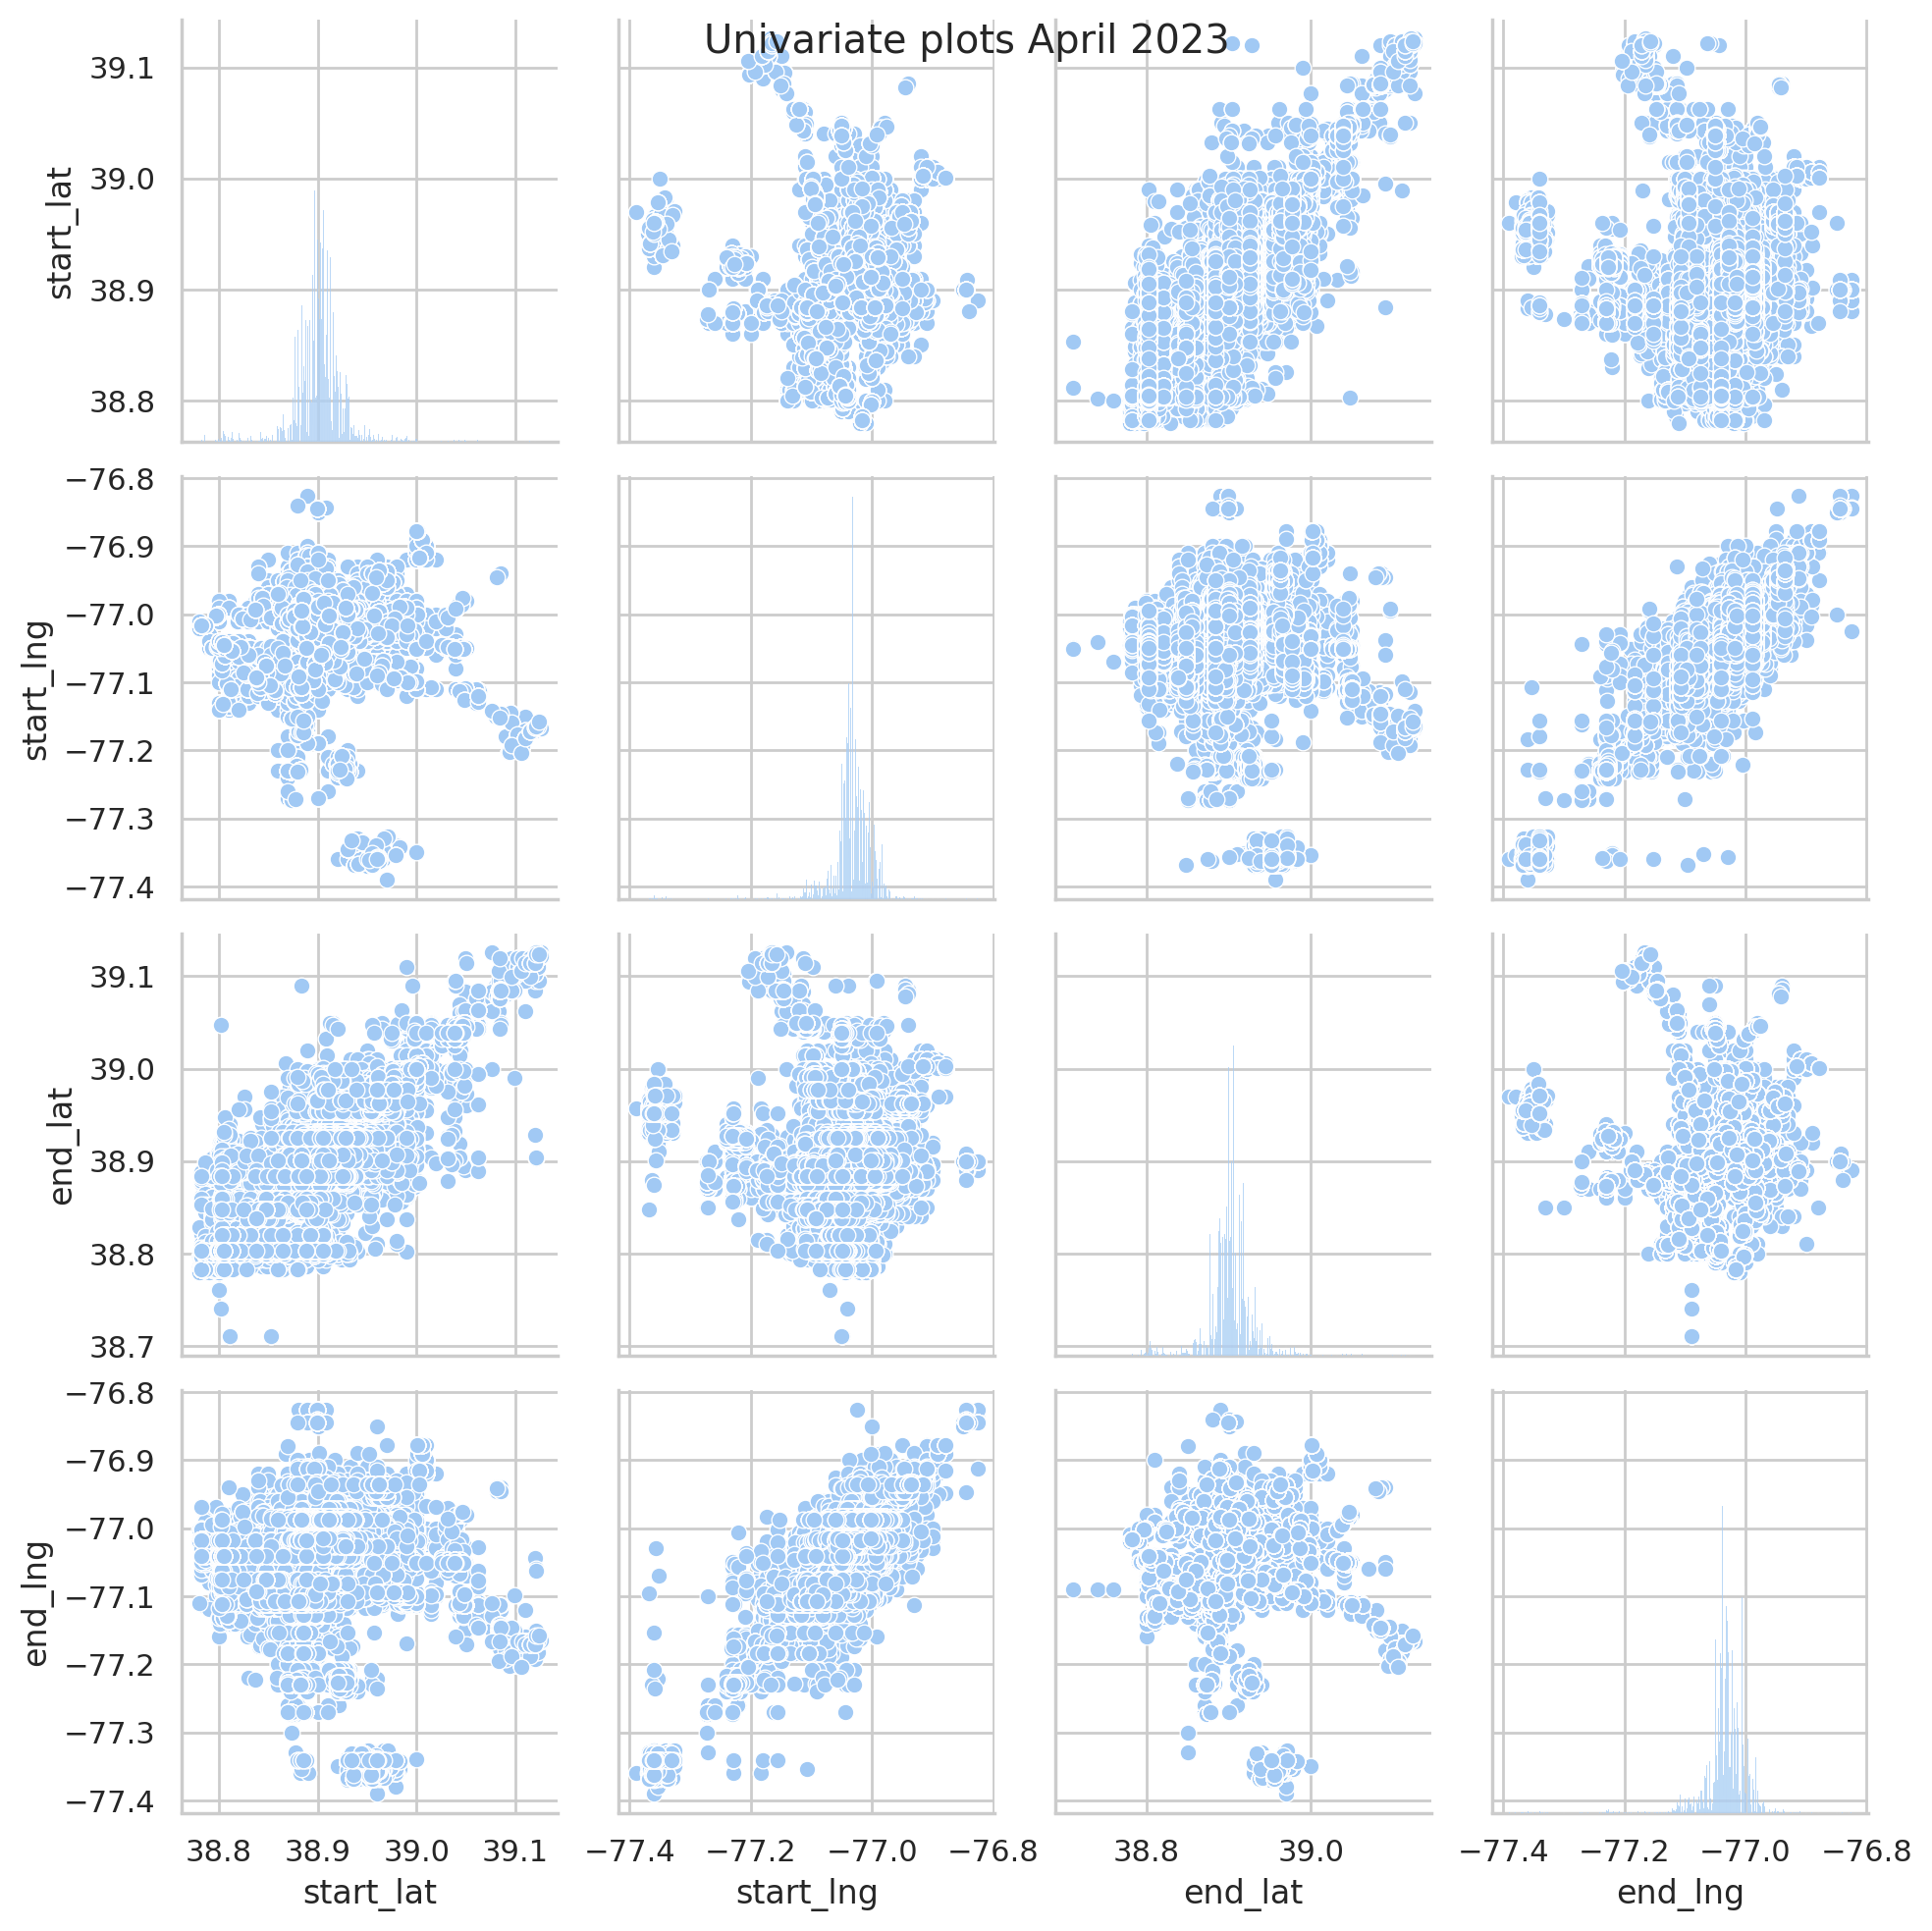

In [13]:
sns.set_theme(style="whitegrid", palette="pastel")

sns.pairplot(df_2023_04.drop(columns = ['start_station_id', 'end_station_id'], axis = 1))
plt.suptitle('Univariate plots April 2023')

# Find information about vehicles and journeys

Questions:
- what is the difference between classic and docked bike? and do scooters not appear on the list?
- how many journeys do not start from a docking station?

## What can the data tell us about the vehicles in use?

check unique vehicle types in this dataset and number of journeys using each

classic_bike     257729
electric_bike    113718
docked_bike       17796
Name: rideable_type, dtype: int64


<Axes: xlabel='rideable_type', ylabel='Count'>

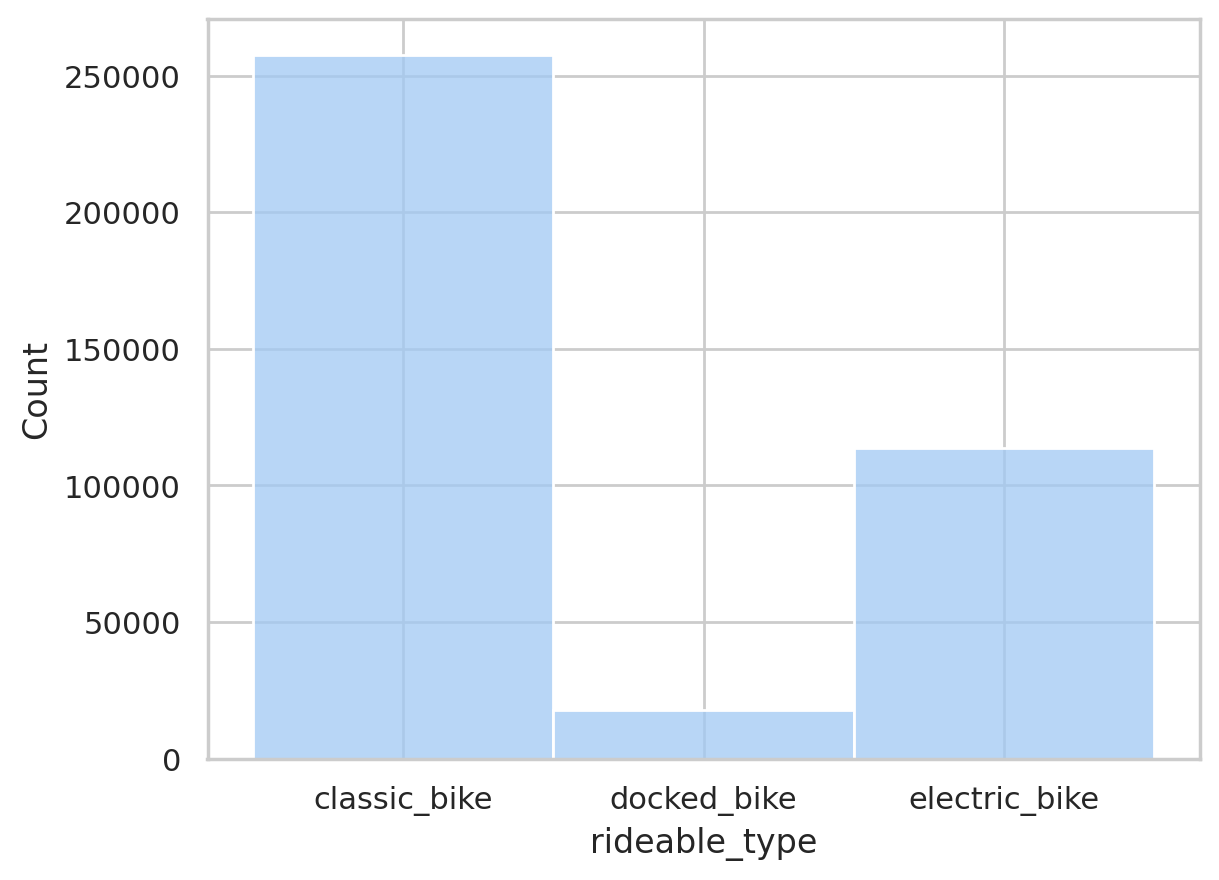

In [14]:
print(df_2023_04.rideable_type.value_counts())
sns.histplot(df_2023_04.rideable_type)

### Did the usage of the three vehicle types change over the month of April? 

make a line plot with three lines for daily counts of vehicle types - this could indicate that one type is being phased out, as new vehicles were introduced this year but it is not clear what label in the dataset represents them


<Axes: xlabel='started_at'>

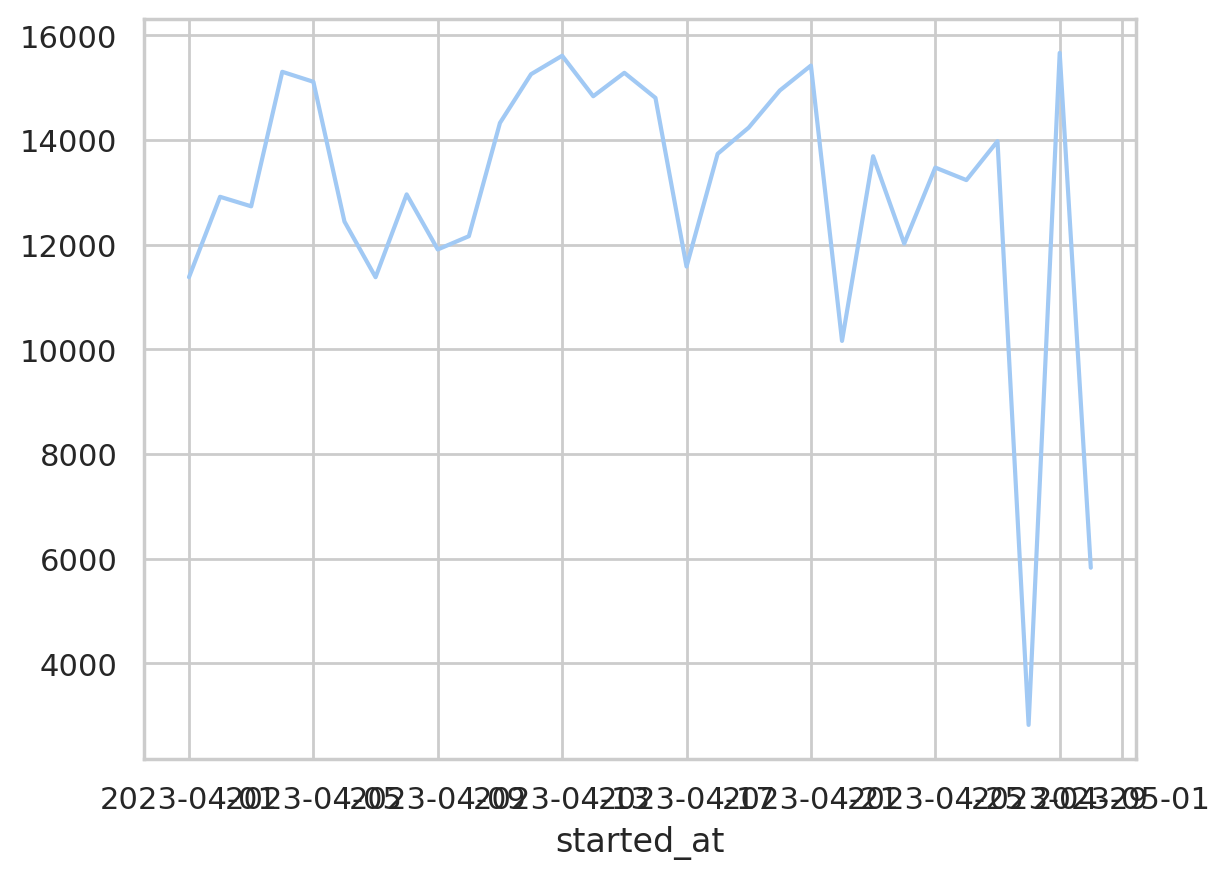

In [15]:
#first, plot all journeys' counts by date - begin with a series of counts grouped by date 
df_per_date = df_2023_04["started_at"].groupby(df_2023_04["started_at"].dt.date).count().plot()
df_per_date

In [16]:
# failed attempts at plotting each rideable type per day:

#df_date_r_t1 = df_2023_04.groupby(["rideable_type", df_2023_04["started_at"].dt.date]).count()
#df_date_r_t1 = df_date_r_t1.reset_index()

# df_per_date_r_t2 = df_2023_04["rideable_type"].groupby(df_2023_04["started_at"].dt.date).count()
# df_per_date_r_t2 = pd.DataFrame(df_per_date_r_t2).reset_index()
# df_per_date_r_t2

# double grouping does not work with any of the graphs I tried. it created a double index, so I needed to use .unstack() :

In [17]:
# plotting each rideable type per day:
#create a new df of item counts (of ride_id) grouped by both date and rideable type, 
#then unstack to remove the resulting mulitindex.
df_per_date_r_t = df_2023_04.groupby([(df_2023_04["started_at"].dt.date), "rideable_type"]).count().unstack().iloc[:, 0:3]
#display(df_per_date_r_t)

<Axes: title={'center': 'Usage of each rideable type per day (April 2023)'}, xlabel='started_at'>

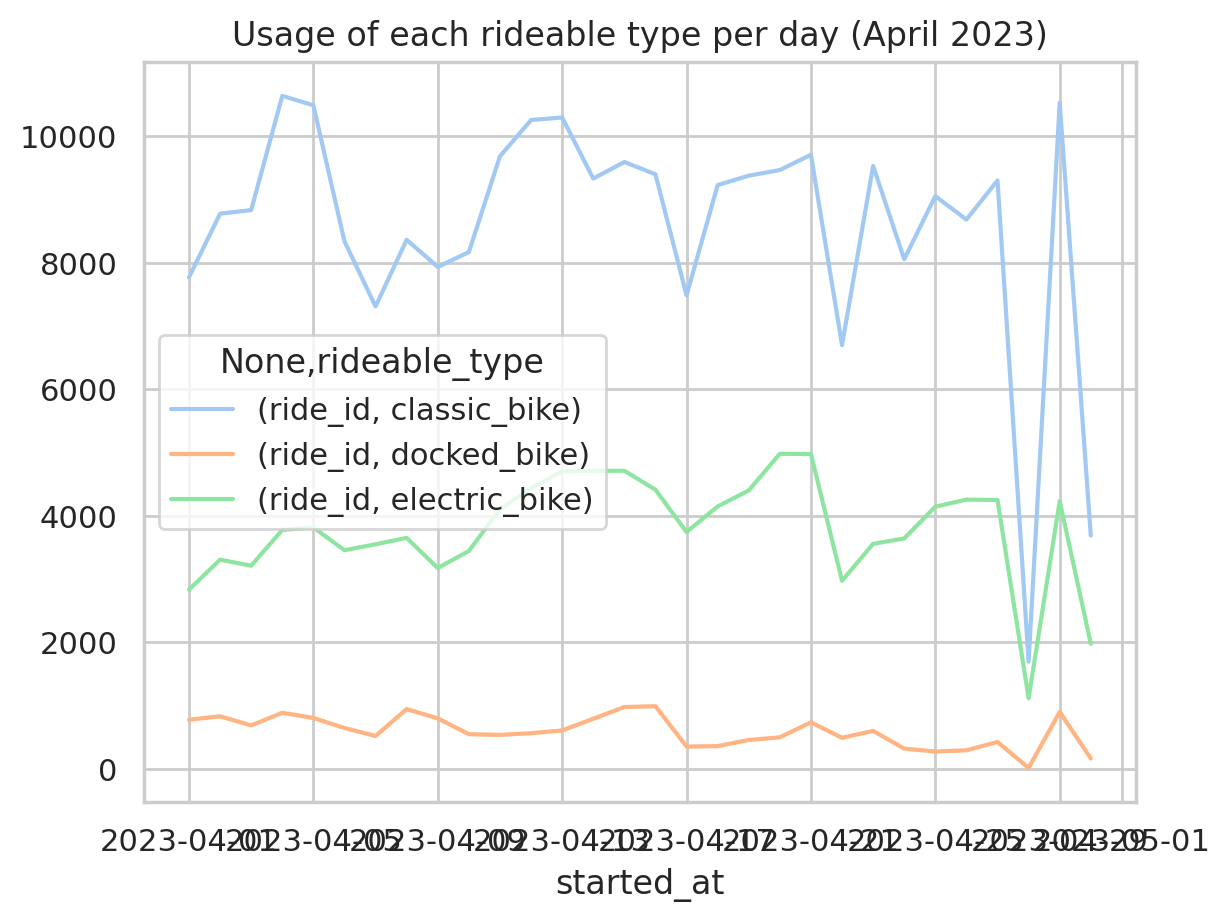

In [18]:
df_per_date_r_t.plot(title="Usage of each rideable type per day (April 2023)")
#TODO: formatting

Which hour-periods of the day did journeys start at (frequency)?

Text(0.5, 1.0, 'Hour-periods when journeys started (April 2023)')

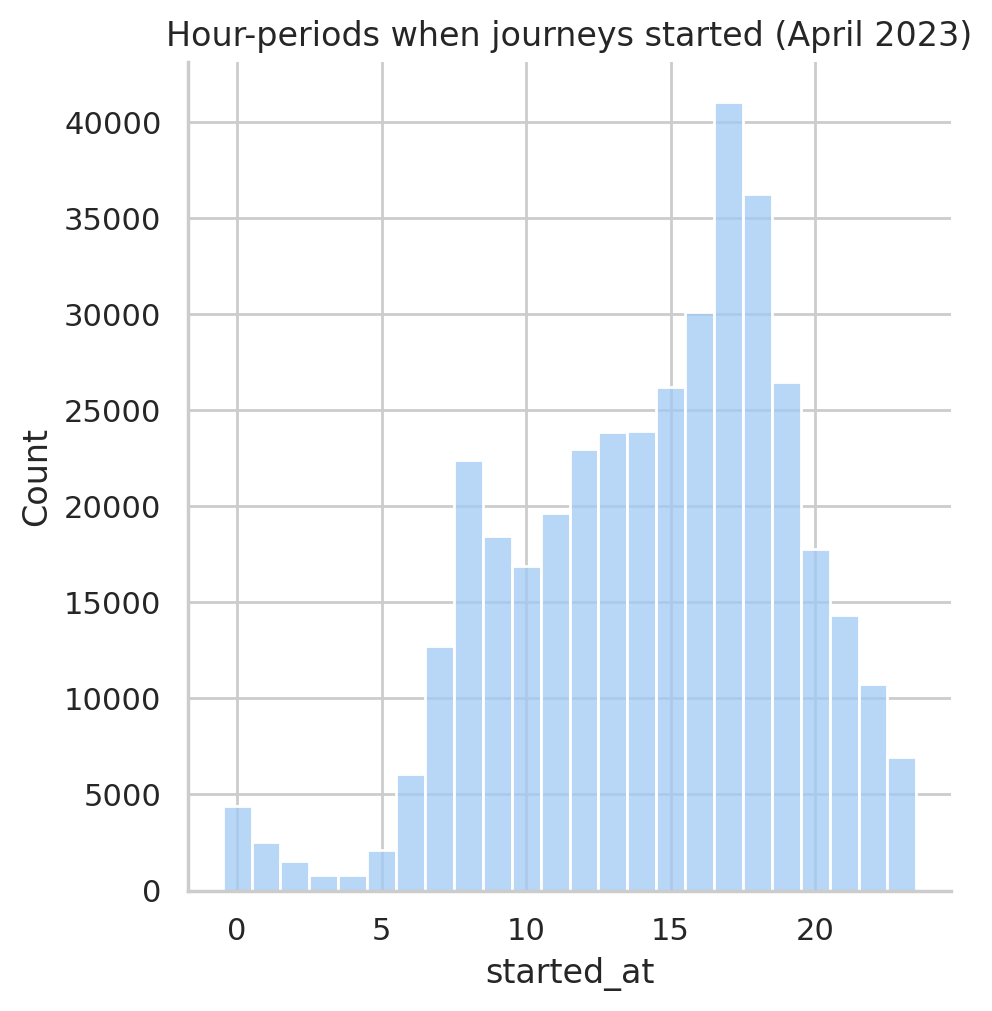

In [19]:
g_hour_dist = sns.displot(data=df_2023_04.started_at.dt.hour, discrete=True)
plt.title("Hour-periods when journeys started (April 2023)")


In [20]:
#TODO: plot on clock as radial histogram? http://qingkaikong.blogspot.com/2016/04/plot-histogram-on-clock.html

Resampling

In [21]:
#TODO: try out resample()

# Do registered riders ride further (net distance)?

In [22]:
# create a straight-line vector distance from the start and end coordinates 
#source for function: https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/#calculate-distance-between-origin-and-dest
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

df_2023_04['distance'] = haversine_vectorize(df_2023_04['start_lng'],df_2023_04['start_lat'],df_2023_04['end_lng'], df_2023_04['end_lat'])

In [33]:
#show overview of net distances
display(df_2023_04.distance, "Max Distance:", df_2023_04.distance.max(), "Mean Distance:", df_2023_04.distance.mean())

0         0.670575
1         3.497933
2         2.712487
3         1.077837
4         1.674044
            ...   
389238    6.211805
389239    1.912751
389240    1.912751
389241    2.805129
389242    1.704084
Name: distance, Length: 389243, dtype: float64

'Max Distance:'

29.009908352858023

'Mean Distance:'

1.879360860625674

In [37]:
#add a new column for elapsed time using logical comparison of datetime objects
df_2023_04['elapsed'] = (df_2023_04.ended_at - df_2023_04.started_at).dt.seconds
df_2023_04.reset_index()
display(df_2023_04)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member,0.670575,329
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member,3.497933,972
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member,2.712487,1007
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member,1.077837,241
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member,1.674044,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389238,EAA293669D7032B0,electric_bike,2023-04-12 17:10:02,2023-04-12 17:33:47,Thomas Jefferson St NW & Water/K St NW,31293.0,13th & H St NE,31611.0,38.902996,-77.060003,38.900427,-76.988250,member,6.211805,1425
389239,E76129D0EB71B579,classic_bike,2023-04-05 17:25:35,2023-04-05 18:04:43,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,2348
389240,5A2E2DED1A83FCFE,classic_bike,2023-04-17 21:18:44,2023-04-17 21:27:38,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,534
389241,AADF7A5217DC964E,classic_bike,2023-04-08 18:11:21,2023-04-08 18:47:46,Lincoln Memorial,31258.0,4th & E St SW,31244.0,38.888255,-77.049436,38.884120,-77.017445,casual,2.805129,2185


In [51]:
#filter journeys of 0 net distance AND time less than 5 minutes (300s), to exclude only false starts but not round trips
df_fs = (df_2023_04[(df_2023_04.distance == 0) & (df_2023_04.elapsed < 300)])
display(df_fs)

#exclude these journeys 
df_2023_04_nfs = df_2023_04.drop(df_fs.index)
df_2023_04_nfs

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
27,FD344697E55AD7DF,classic_bike,2023-04-20 12:42:38,2023-04-20 12:43:27,N. Beauregard St. & Berkley St.,31928.0,N. Beauregard St. & Berkley St.,31928.0,38.841548,-77.107734,38.841548,-77.107734,casual,0.0,49
28,8EDE4DB51771DD4D,classic_bike,2023-04-16 14:34:53,2023-04-16 14:35:51,23rd & E St NW,31260.0,23rd & E St NW,31260.0,38.896104,-77.049882,38.896104,-77.049882,member,0.0,58
29,A9798CD761782CE4,classic_bike,2023-04-11 14:52:34,2023-04-11 14:53:02,20th & Columbia Rd NW,31133.0,20th & Columbia Rd NW,31133.0,38.918036,-77.045487,38.918036,-77.045487,member,0.0,28
57,EE800B109F81F72D,classic_bike,2023-04-23 14:29:10,2023-04-23 14:29:12,The Mall at Prince Georges,32422.0,The Mall at Prince Georges,32422.0,38.968842,-76.954171,38.968842,-76.954171,member,0.0,2
79,C29A78FC4DFF7119,classic_bike,2023-04-24 12:19:30,2023-04-24 12:19:36,15th & W St NW,31125.0,15th & W St NW,31125.0,38.919018,-77.034449,38.919018,-77.034449,member,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389152,A2D5C4F15AD02681,classic_bike,2023-04-11 13:02:29,2023-04-11 13:06:26,Wheaton Metro / Georgia Ave & Reedie Dr,32062.0,Wheaton Metro / Georgia Ave & Reedie Dr,32062.0,39.038424,-77.051020,39.038424,-77.051020,casual,0.0,237
389154,29C4A3A5036C1FD2,classic_bike,2023-04-16 13:43:12,2023-04-16 13:43:14,31st St & S Woodrow St,31072.0,31st St & S Woodrow St,31072.0,38.837846,-77.093478,38.837846,-77.093478,casual,0.0,2
389160,9337ADF1A02911E5,classic_bike,2023-04-23 19:58:50,2023-04-23 20:01:55,4th & E St SW,31244.0,4th & E St SW,31244.0,38.884120,-77.017445,38.884120,-77.017445,casual,0.0,185
389161,2886F44A93D66D57,classic_bike,2023-04-23 19:59:26,2023-04-23 20:00:13,4th & E St SW,31244.0,4th & E St SW,31244.0,38.884120,-77.017445,38.884120,-77.017445,casual,0.0,47


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member,0.670575,329
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member,3.497933,972
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member,2.712487,1007
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member,1.077837,241
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member,1.674044,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389238,EAA293669D7032B0,electric_bike,2023-04-12 17:10:02,2023-04-12 17:33:47,Thomas Jefferson St NW & Water/K St NW,31293.0,13th & H St NE,31611.0,38.902996,-77.060003,38.900427,-76.988250,member,6.211805,1425
389239,E76129D0EB71B579,classic_bike,2023-04-05 17:25:35,2023-04-05 18:04:43,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,2348
389240,5A2E2DED1A83FCFE,classic_bike,2023-04-17 21:18:44,2023-04-17 21:27:38,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,534
389241,AADF7A5217DC964E,classic_bike,2023-04-08 18:11:21,2023-04-08 18:47:46,Lincoln Memorial,31258.0,4th & E St SW,31244.0,38.888255,-77.049436,38.884120,-77.017445,casual,2.805129,2185


<Axes: xlabel='distance', ylabel='Count'>

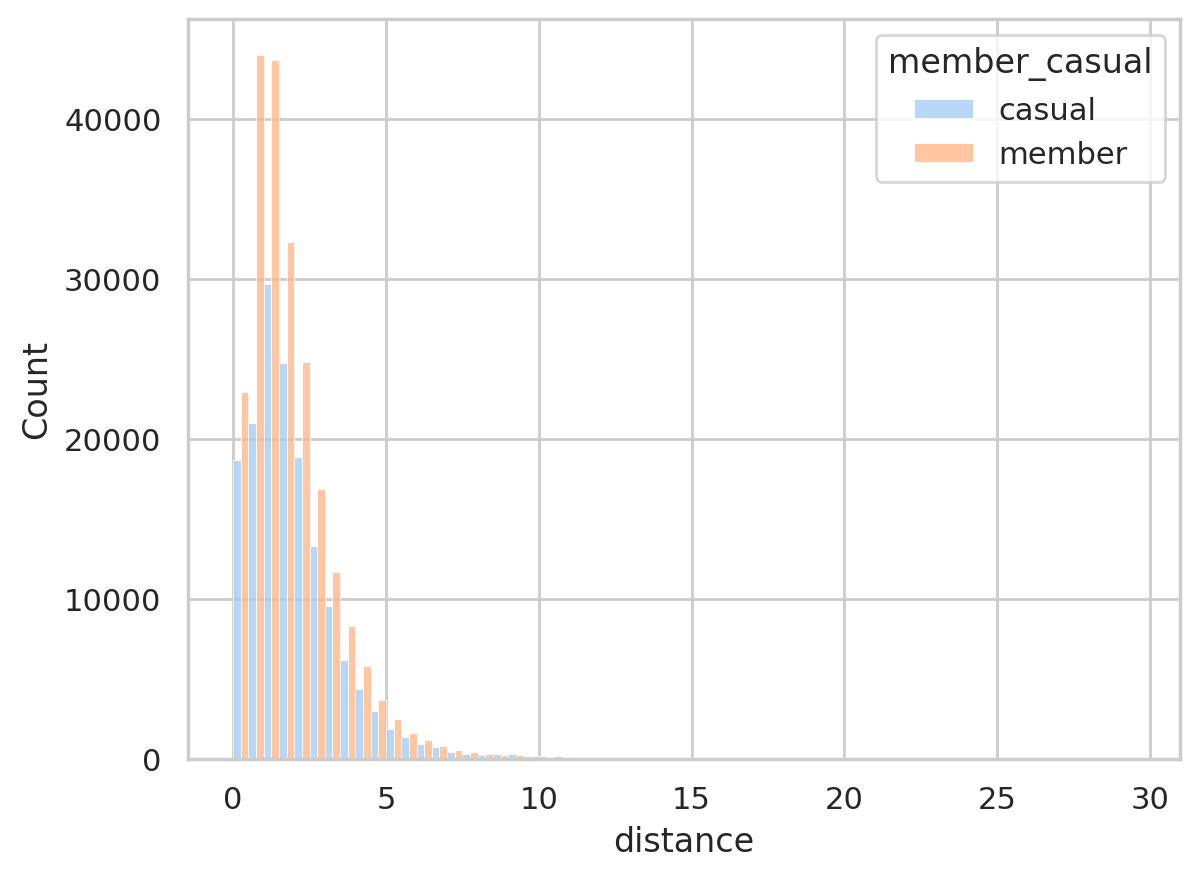

In [52]:
# plot net distance excluding false starts by member status
sns.histplot(data=df_2023_04_nfs, x='distance', binwidth=0.5, hue='member_casual', multiple="dodge")
# plt.ylim(0, 80000)
# plt.xlim(0, 30)


In [25]:
# fig, axes=plt.subplots(1,2)

# sns.set_style('darkgrid')
# sns.scatterplot(ax=axes[0], data=df_hour, y=df_hour.cnt, x=df_hour.windspeed, hue='registered_proportion')
# axes[0].set_title('Windspeed')

# sns.scatterplot(ax=axes[1],data=df_hour, y=df_hour.cnt, x=df_hour.temp, hue='registered_proportion')
# axes[1].set_title('Temperature (Normalized)')

# fig.suptitle('Count of rides by windspeed and temperature')

# plt.tight_layout()

## Boxplot of day-wise Distribution

In [26]:
#TODO: sns.boxplot(data=df_2023_04, x='', y='')

# Trips per day per bicycle (TDB)
This is a metric proposed for the success of a bike sharing scheme bye Médard de Chardon et al. (2017)

# Multivariate analysis: heatmap

In [27]:
#TODO

# Time Series Analysis

# Time Series line graphs

In [28]:
# x = df_day['dteday']
# y = df_day['cnt']

# plt.plot(x, y)

# plt.title('Rides per day')
# plt.xlabel('Date')
# plt.ylabel('Rides')

Linear regression with time series

In [29]:
#TODO

In [30]:
import pandas as pd
multi_index = pd.MultiIndex.from_tuples([("r0", "rA"),
                                       ("r1", "rB")],
                                       names=['Courses','Fee'])
cols = pd.MultiIndex.from_tuples([("Gasoline", "Toyoto"), 
                                  ("Gasoline", "Ford"), 
                                  ("Electric", "Tesla"),
                                  ("Electric", "Nio")])

data=[[100,300, 900,400 ], [200,500, 300,600]]

df = pd.DataFrame(data, columns=cols,index=multi_index)
print(df)

            Gasoline      Electric     
              Toyoto Ford    Tesla  Nio
Courses Fee                            
r0      rA       100  300      900  400
r1      rB       200  500      300  600


In [31]:

# MultiIndex to Single Index
df2 = df.reset_index(level=[1])
print(df2)


        Fee Gasoline      Electric     
              Toyoto Ford    Tesla  Nio
Courses                                
r0       rA      100  300      900  400
r1       rB      200  500      300  600


In [32]:

# Convert Multi-index to Columns
df2=df.reset_index()
print(df2)


  Courses Fee Gasoline      Electric     
                Toyoto Ford    Tesla  Nio
0      r0  rA      100  300      900  400
1      r1  rB      200  500      300  600
